In [12]:
import xarray as xr
import matplotlib.pyplot as plt
from utility import analysis_parameters as ap
import cartopy.crs as ccrs
import numpy as np

model="SAM"
var = "clivi"

In [13]:
file = ap.get_timmean_file(model, var)

In [14]:
var_ds = xr.open_dataset(file)[var]
var_ds

<xarray.DataArray 'clivi' (time: 1, lat: 1612, lon: 9216)>
[14856192 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-02-09T12:00:00
  * lon      (lon) float32 0.0 0.03906 0.07812 0.1172 ... 359.9 359.9 360.0
  * lat      (lat) float32 -29.99 -29.96 -29.93 -29.89 ... 29.93 29.96 29.99
Attributes:
    standard_name:  atmosphere_mass_content_of_cloud_ice
    long_name:      Ice Path
    units:          kg/m2
    cell_methods:   time: mean
    origin:         IWP

In [15]:
var_ds = var_ds.sortby(var_ds.lon)
var_ds = var_ds.sortby(var_ds.lat)

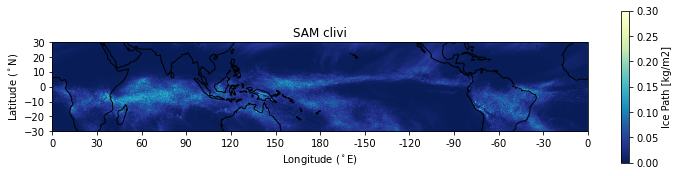

In [16]:
fig = plt.figure(figsize=(12,4))
axis = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

var_ds.isel(time=0).plot(
    ax=axis,
    transform=ccrs.PlateCarree(),  
    cmap="YlGnBu_r",
    vmin=0, vmax=0.3,
    cbar_kwargs={"orientation": "vertical", "shrink": 0.7},
    robust=True
)

axis.coastlines() 
axis.set_xticks(np.arange(-180,181,30))
axis.set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0])
axis.set_yticks(np.arange(-30,31,10))
axis.set_title(model+" "+var)
axis.set_xlabel("Longitude ($^\circ$E)")
axis.set_ylabel("Latitude ($^\circ$N)")
plt.savefig("../plots/GT/timmean_{}_{}.png".format(model, var), dpi=150)
plt.show()